Presence of the following datasets is required.<br>
`./datasets/MultiWOZ`<br>
`./datasets/e2e`<br>
`./datasets/taskmaster`

In [1]:
# Control whether the network should run on GPU or CPU
USE_CPU=True

In [2]:
import os
import tensorflow as tf

# CPU or GPU
if USE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

    # GPU presence check
    if tf.test.gpu_device_name():
        print('GPU found')
    else:
        print("No GPU found")

No GPU found


In [3]:
!nvidia-smi

Sat Jul 18 18:12:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   35C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## End-of-speech classification

In [4]:
import json # for reading the .json files (dialog dataset)
import numpy as np

In [5]:
# from MultiWOZ-Parser; reading the names of the files for training, testing, validation datasets
# https://github.com/jojonki/MultiWOZ-Parser/blob/master/parser.py

def load_json(data_file):
    if os.path.isfile(data_file):
        with open(data_file, 'r') as read_file:
            data = json.load(read_file)
            return data

def load_list_file(list_file):
    with open(list_file, 'r') as read_file:
        dialog_id_list = read_file.readlines()
        dialog_id_list = [l.strip('\n') for l in dialog_id_list]
        return dialog_id_list
    return

In [6]:
# extracting data
dialog_data_file = './datasets/MultiWOZ/data.json'
dialog_data = load_json(dialog_data_file)
dialog_id_list = list(set(dialog_data.keys()))

valid_list_file = './datasets/MultiWOZ/valListFile.json'
test_list_file = './datasets/MultiWOZ/testListFile.json'

valid_id_list = list(set(load_list_file(valid_list_file)))
test_id_list = load_list_file(test_list_file)
train_id_list = [did for did in dialog_id_list if did not in (valid_id_list + test_id_list)]

train_data = [v for k, v in dialog_data.items() if k in train_id_list]
valid_data = [v for k, v in dialog_data.items() if k in valid_id_list]
test_data = [v for k, v in dialog_data.items() if k in test_id_list]

In [7]:
# merging all datasets together
data = train_data + valid_data + test_data

In [8]:
import re # for regex

def text_tokens(text):
    # transforming to lowercase
    text = text.lower()
    # replacing whitespace characters with spaces
    text = re.sub("\\s", " ", text)
    # removing everything that is not a letter
    text = re.sub("[^a-zA-Z ']", "", text)
    
    # splitting string into array based on spaces
    tokens = text.split(' ')
    
    # removing empty strings from the tokens array
    tokens = list(filter(('').__ne__, tokens))
    
    return tokens

In [9]:
# from MultiWOZ-Parser
# https://github.com/jojonki/MultiWOZ-Parser/blob/master/parser.py

def get_dst_diff(prev_d, crnt_d):
    assert len(prev_d) == len(crnt_d)
    diff = {}
    for ((k1, v1), (k2, v2)) in zip(prev_d.items(), crnt_d.items()):
        assert k1 == k2
        if v1 != v2: # updated
            diff[k2] = v2
    return diff

def get_lines(d):
    assert 'log' in d
    assert 'goal' in d
    domains = []
    ignore_keys_in_goal = ['eod', 'messageLen', 'message'] # eod (probably) means the user archieved the goal. 
    for dom_k, dom_v  in d['goal'].items():
        if dom_v and dom_k not in ignore_keys_in_goal: # check whether contains some goal entities
            domains.append(dom_k)
            
    lines = []
    
    prev_d = None
    for i, t in enumerate(d['log']):
        spk = 'Usr' if i % 2 == 0 else 'Sys' # Turn 0 is always a user's turn in this corpus.
        if spk == 'Sys':
            if prev_d is None:
                prev_d = t['metadata']
            else:
                crnt_d = t['metadata']
                dst_diff = get_dst_diff(prev_d, crnt_d)
                prev_d = crnt_d

        lines.append(text_tokens(t['text']))

    return lines

In [10]:
def to_array(data):
    # extracting dialogs from data
    dialogs = [get_lines(dialog) for dialog in data]

    s = []
    # extracting individual dialogs
    for sentences in dialogs:
        # extracting each conversation turn
        for sentence in sentences: 
            s.append(sentence)
        
    return s

In [11]:
# list of individual conversation turns from MultiWOZ dataset
data_full = to_array(data)

In [12]:
# data examples
print(' '.join(data_full[0]))
print(' '.join(data_full[1]))
print(' '.join(data_full[2]))
print(' '.join(data_full[3]))
print(' '.join(data_full[4]))

am looking for a place to to stay that has cheap price range it should be in a type of hotel
okay do you have a specific area you want to stay in
no i just need to make sure it's cheap oh and i need parking
i found cheap hotel for you that includes parking do you like me to book it
yes please people nights starting on tuesday


In [13]:
from collections import Counter # counting the occurrences of words in the dataset

# creating a vocabulary of the top most frequent words in the dataset
vocab = []
for sentence in data_full:
    for word in sentence:
        vocab.append(word)

VOCAB_SIZE=3000 # constant for the vocabulary size

d = Counter(vocab) # count number of occurrences
q = d.most_common()[0:VOCAB_SIZE] # create vocabulary of VOCAB_SIZE most common words
vocab_top = [q[i][0] for i in range(VOCAB_SIZE)] # extracting the words from Counter structure

---
# Network implementation

### MultiWOZ dataset

In [14]:
# From Deep Learning for Text Processing Workshop at Machine Learning Prague 2018
# https://github.com/rossumai/mlprague18-nlp

# Creating dictionary of each word in the pre-trained GloVe embeddings, saving its location indexes 

EMBEDDING_DIM = 50

embeddings_index = {}
# using the GloVe word embeddings
f = open(os.path.join('glove.6B.%dd.txt' % EMBEDDING_DIM), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [15]:
# a matrix that is indexed by our vocabulary, containing GloVe embedding for each vocabulary element
embedding_matrix = np.zeros((len(vocab_top) + 1, EMBEDDING_DIM))
for i, word in enumerate(vocab_top):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros; also, [0] is reserved for padding.
        embedding_matrix[i + 1] = embedding_vector

In [16]:
def vocab_indices_vector(tokens):
    vector = [0] * seq_cutoff
    
    for i, t in enumerate(tokens):
        try:
            vector[i] = vocab_top.index(t) + 1 # reserving 0 for padding
        except:
            pass # ignore missing words
        
    return vector

In [17]:
import random

def split_data(data):
    X = []
    Y = []
    for i in range(len(data)):
        if (len(data[i]) > 60):
            # too long senteces are cut by default
            X.append(data[i])
            Y.append(0)
        else:
            if (len(data[i]) > 1):
                if (i <= (3*len(data))//4):
                    # picking random point for splitting the conversation turn
                    l = random.randrange(1, len(data[i]))
                    # splitting data
                    X.append(data[i][:l])
                    # adding 0 to the target list -> 0 -- interrupted turn 
                    Y.append(0)

                # second section of the dataset is made out of full conversation turns
                else:
                    # adding the full uninterrupted conversation turn
                    X.append(data[i])
                    # adding 1 to the target list -> 1 -- uninterrupted turn 
                    Y.append(1)
            
    # shuffling the dataset
    c = list(zip(X, Y, data))
    random.shuffle(c)
    X, Y, data = zip(*c)
    
    # vectorizing the data
    X = [vocab_indices_vector(x) for x in X]
    
    return X,Y,data

In [18]:
lengths = sorted([len(x) for x in data_full]) # sorted lengths of the all reviews
percentile = 0.90 # we are looking at reviews that are short, the 10% making the long reviews
seq_cutoff = lengths[-1]
print(
    'Longest: %d, Average: %f, Median: %d, %d%% percentile: %d tokens' % 
    (lengths[-1], np.mean(lengths), lengths[int(len(lengths)*0.5)], percentile*100, seq_cutoff)
)

Longest: 61, Average: 12.765652, Median: 12, 90% percentile: 61 tokens


In [19]:
# ratio of words not included in the GloVe matrix
1. * np.count_nonzero(np.all(embedding_matrix == 0, axis=1)) / len(vocab)

0.0002371172240746815

In [20]:
X, Y, data_clean = split_data(data_full)

In [21]:
# splitting into training and validating parts
# 2/3 for training, 1/3 for validating
s = (len(X)//3)*2

X_train = X[:s]
Y_train = Y[:s]

X_val = X[s+1:]
Y_val = Y[s+1:]

---

In [22]:
# NN from Deep Learning for Text Processing Workshop at Machine Learning Prague 2018
# https://github.com/rossumai/mlprague18-nlp

from tensorflow.keras.layers import Activation, Conv1D, Dense, Embedding, GlobalMaxPooling1D, Input, Dropout
from tensorflow.keras.models import Model
import numpy as np

class GloveCNNAwesomeSentimentModel(object):
    def __init__(self, N=256, size=3):
        self.model = self.create(N, size)
        self.model.summary()
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
    def create(self, N, size):
        seq_indices = Input(shape=(seq_cutoff,), name='seq_input') 
        seq_embedded = Embedding(input_dim=len(vocab_top) + 1, output_dim=EMBEDDING_DIM,
                                 input_length=seq_cutoff)(seq_indices)
        seq_conv = Conv1D(N, size, activation='relu')(Dropout(0.2)(seq_embedded)) # dropout - 0.2
        max_conv = GlobalMaxPooling1D()(seq_conv)
        hidden_repr = Dense(N, activation='relu')(max_conv)
        sentiment = Dense(1, activation='sigmoid')(Dropout(0.2)(hidden_repr))

        return Model(inputs=[seq_indices], outputs=[sentiment])

    def train(self, X, y, X_val, y_val,EPOCHS=10):
        print('Fitting...')
        return self.model.fit(np.array(X), np.array(y), 
                              validation_data=(np.array(X_val), np.array(y_val)),
                              epochs=EPOCHS, verbose=1)

    def predict(self, X):
        return self.model.predict(np.array(X))

In [23]:
sentiment = GloveCNNAwesomeSentimentModel()
history = sentiment.train(
    X_train, Y_train, X_val, Y_val
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
seq_input (InputLayer)       [(None, 61)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 61, 50)            150050    
_________________________________________________________________
dropout (Dropout)            (None, 61, 50)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 59, 256)           38656     
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0     

In [24]:
# test of the network
for i in range(200,210):
    if np.random.uniform() > 0.5:
        if (len(data_clean[i]) > 4):
            # picking random point for splitting the conversation turn
            l = random.randrange(1, len(data_clean[i]) - 3)

            test_tokens = text_tokens(' '.join(str(e) for e in data_clean[i][:l]))
            prediction = sentiment.predict([vocab_indices_vector(test_tokens)])[0][0]
            
            print(0, np.around(prediction, 5), ' '.join(str(e) for e in data_clean[i][:l]))
    else:
        test_tokens = text_tokens(' '.join(str(e) for e in data_clean[i]))
        prediction = sentiment.predict([vocab_indices_vector(test_tokens)])[0][0]

        print(1, np.around(prediction, 5), ' '.join(str(e) for e in data_clean[i]))

0 1e-05 that
0 0.00087 there are many trains that fit your needs on sunday do you
0 0.00141 booking was successful
0 0.49654 i would like to keep it cheap
0 0.32139 is that one cheap
0 0.0 you're very
0 0.0 a
0 0.47026 can you find me a train that goes to the cambridge museum
1 0.96267 sure can i just get the travel time and departure time please
0 0.02082 i will also need to book a taxi for commuting between


In [25]:
# PRECISION ANALYSIS BASED ON THE LENGHT OF THE ANALYSED SENTENCES

res_X = [[] for i in range(61)]
res_Y = [[] for i in range(61)]
res_clean = [[] for i in range(61)]
results = []

for i in range(len(data_clean)):
    if len(data_clean[i]) < 60:
        res_X[len(data_clean[i])].append(X[i])
        res_Y[len(data_clean[i])].append(Y[i])
        res_clean[len(data_clean[i])].append(data_clean[i])

zeros = []
ones = []
        
for i in range(1,61):
    print(i)
    print('Sentence len:', i, ', number of sentences:', len(res_clean[i]))
    
    zeros_ = len(np.array(res_Y[i])[np.array(res_Y[i]) == 0])
    ones_ = len(np.array(res_Y[i])[np.array(res_Y[i]) == 1])
    
    print('0:', zeros_, '1:', ones_)
    
    zeros.append(zeros_)
    ones.append(ones_)
    
    
    if zeros_ + ones_ > 0:
        results.append(sentiment.model.evaluate(res_X[i], res_Y[i]))
    else:
        results.append([0,0])

1
Sentence len: 1 , number of sentences: 147
0: 128 1: 19
147/147 [==============================] - 0s 105us/sample - loss: 0.1023 - accuracy: 0.9524
2
Sentence len: 2 , number of sentences: 455
0: 361 1: 94
455/455 [==============================] - 0s 92us/sample - loss: 0.1566 - accuracy: 0.9407
3
Sentence len: 3 , number of sentences: 2459
0: 1966 1: 493
2459/2459 [==============================] - 0s 87us/sample - loss: 0.1676 - accuracy: 0.9341
4
Sentence len: 4 , number of sentences: 4636
0: 3555 1: 1081
4636/4636 [==============================] - 0s 84us/sample - loss: 0.1705 - accuracy: 0.9305
5
Sentence len: 5 , number of sentences: 6651
0: 4961 1: 1690
6651/6651 [==============================] - 1s 84us/sample - loss: 0.1844 - accuracy: 0.9256
6
Sentence len: 6 , number of sentences: 8776
0: 6596 1: 2180
8776/8776 [==============================] - 1s 85us/sample - loss: 0.1805 - accuracy: 0.9266
7
Sentence len: 7 , number of sentences: 9761
0: 7421 1: 2340
9761/9761 [===

In [26]:
import matplotlib.pyplot as plt


plt.plot([results[i][1] for i in range(len(results)) if len], label='Accuracy')
plt.xlim(0,40)
plt.ylim(0.75,1.05)
# plt.plot(l_er, label='Loss')
plt.xlabel('Sentence length in words')
plt.legend()
plt.show()

<Figure size 640x480 with 1 Axes>

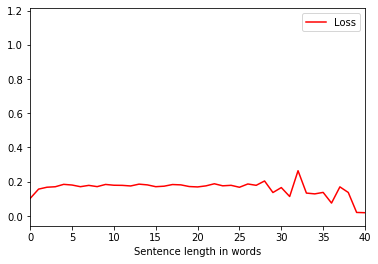

In [27]:
plt.plot([results[i][0] for i in range(len(results)) if len], label='Loss', c='red')
plt.xlim(0,40)
# plt.ylim(0.75,1.05)
plt.xlabel('Sentence length in words')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Sentences length distribution')

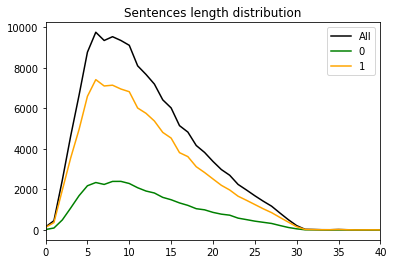

In [28]:
plt.plot(np.array(zeros) + np.array(ones), c='black', label='All')
plt.plot(np.array(ones), c='green', label='0')
plt.plot(np.array(zeros), c='orange', label='1')
plt.xlim(0,40)
plt.legend()
# plt.yscale('log')

plt.title('Sentences length distribution')

---

### E2E dataset

In [29]:
import pandas as pd

restaurant_data = pd.read_csv('datasets/e2e/restaurant_all.tsv', sep='\t',error_bad_lines=False,warn_bad_lines=False)['Message.Text']
taxi_data = pd.read_csv('datasets/e2e/taxi_all.tsv', sep='\t',error_bad_lines=False,warn_bad_lines=False)['Message.Text']
movie_data = pd.read_csv('datasets/e2e/movie_all.tsv', sep='\t',error_bad_lines=False,warn_bad_lines=False)['Message.Text']

In [30]:
print(restaurant_data[12])

No I really need Sunday - Does either of the other 2 places have an opening? Like Flatbread Neapolitan Pizzeria and it can be anywhere from 11 am - 2 pm


In [31]:
def e2eGetter(data):
    sentences = []
    for sentence in data:
        if isinstance(sentence, str):
            sentences.append(text_tokens(sentence))
    
    return sentences

In [32]:
# merging data together
r_data = e2eGetter(restaurant_data)
t_data = e2eGetter(taxi_data)
m_data = e2eGetter(movie_data)

e2e_data = r_data + t_data + m_data

In [33]:
e2e_X, e2e_Y, e2e_data_clean = split_data(e2e_data)

In [34]:
# splitting into training and validating parts
# 2/3 for training, 1/3 for validating
e2e_s = (len(e2e_X)//3)*2

e2e_X_train = e2e_X[:e2e_s]
e2e_Y_train = e2e_Y[:e2e_s]
e2e_X_val = e2e_X[e2e_s+1:]
e2e_Y_val = e2e_Y[e2e_s+1:]

In [35]:
sentiment = GloveCNNAwesomeSentimentModel()
history = sentiment.train(
    e2e_X_train, e2e_Y_train, e2e_X_val, e2e_Y_val
)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
seq_input (InputLayer)       [(None, 61)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 61, 50)            150050    
_________________________________________________________________
dropout_2 (Dropout)          (None, 61, 50)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 59, 256)           38656     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0   

In [36]:
# PRECISION ANALYSIS BASED ON THE LENGHT OF THE ANALYSED SENTENCES

res_X = [[] for i in range(61)]
res_Y = [[] for i in range(61)]
res_clean = [[] for i in range(61)]
results = []

for i in range(len(e2e_data_clean)):
    if len(e2e_data_clean[i]) < 60:
        res_X[len(e2e_data_clean[i])].append(e2e_X[i])
        res_Y[len(e2e_data_clean[i])].append(e2e_Y[i])
        res_clean[len(e2e_data_clean[i])].append(e2e_data_clean[i])

zeros = []
ones = []
        
for i in range(1,61):
    print(i)
    print('Sentence len:', i, ', number of sentences:', len(res_clean[i]))
    
    zeros_ = len(np.array(res_Y[i])[np.array(res_Y[i]) == 0])
    ones_ = len(np.array(res_Y[i])[np.array(res_Y[i]) == 1])
    
    print('0:', zeros_, '1:', ones_)
    
    zeros.append(zeros_)
    ones.append(ones_)
    
    
    if zeros_ + ones_ > 0:
        results.append(sentiment.model.evaluate(res_X[i], res_Y[i]))
    else:
        results.append([0,0])

1
Sentence len: 1 , number of sentences: 5472
0: 3588 1: 1884
5472/5472 [==============================] - 1s 103us/sample - loss: 0.1146 - accuracy: 0.9662
2
Sentence len: 2 , number of sentences: 4531
0: 3484 1: 1047
4531/4531 [==============================] - 0s 85us/sample - loss: 0.1072 - accuracy: 0.9658
3
Sentence len: 3 , number of sentences: 3560
0: 2772 1: 788
3560/3560 [==============================] - 0s 86us/sample - loss: 0.0938 - accuracy: 0.9713
4
Sentence len: 4 , number of sentences: 2905
0: 2197 1: 708
2905/2905 [==============================] - 0s 86us/sample - loss: 0.0992 - accuracy: 0.9673
5
Sentence len: 5 , number of sentences: 2655
0: 2206 1: 449
2655/2655 [==============================] - 0s 85us/sample - loss: 0.0969 - accuracy: 0.9631
6
Sentence len: 6 , number of sentences: 4153
0: 3480 1: 673
4153/4153 [==============================] - 0s 84us/sample - loss: 0.0828 - accuracy: 0.9716
7
Sentence len: 7 , number of sentences: 2864
0: 2224 1: 640
2864/2

55
Sentence len: 55 , number of sentences: 4
0: 3 1: 1
4/4 [==============================] - 0s 670us/sample - loss: 0.0567 - accuracy: 1.0000
56
Sentence len: 56 , number of sentences: 4
0: 4 1: 0
4/4 [==============================] - 0s 696us/sample - loss: 7.5545e-04 - accuracy: 1.0000
57
Sentence len: 57 , number of sentences: 4
0: 4 1: 0
4/4 [==============================] - 0s 634us/sample - loss: 0.0010 - accuracy: 1.0000
58
Sentence len: 58 , number of sentences: 5
0: 5 1: 0
5/5 [==============================] - 0s 538us/sample - loss: 9.2290e-04 - accuracy: 1.0000
59
Sentence len: 59 , number of sentences: 6
0: 6 1: 0
6/6 [==============================] - 0s 653us/sample - loss: 0.0197 - accuracy: 1.0000
60
Sentence len: 60 , number of sentences: 0
0: 0 1: 0


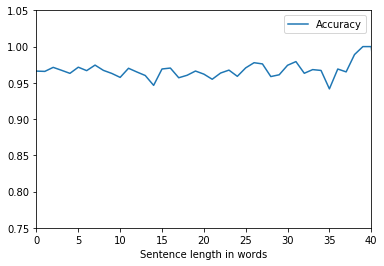

In [37]:
plt.plot([results[i][1] for i in range(len(results)) if len], label='Accuracy')
plt.xlim(0,40)
plt.ylim(0.75,1.05)
# plt.plot(l_er, label='Loss')
plt.xlabel('Sentence length in words')
plt.legend()
plt.show()

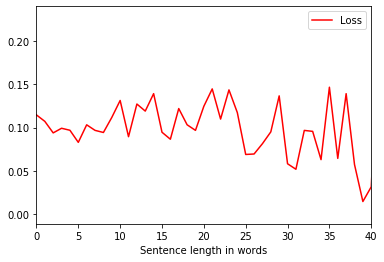

In [38]:
plt.plot([results[i][0] for i in range(len(results)) if len], label='Loss', c='red')
plt.xlim(0,40)
# plt.ylim(0.75,1.05)
plt.xlabel('Sentence length in words')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Sentence length distribution')

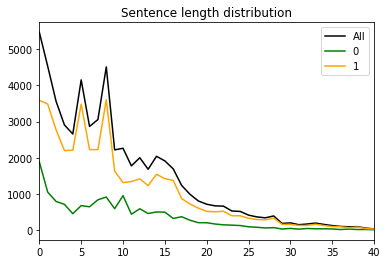

In [39]:
plt.plot(np.array(zeros) + np.array(ones), c='black', label='All')
plt.plot(np.array(ones), c='green', label='0')
plt.plot(np.array(zeros), c='orange', label='1')
plt.xlim(0,40)
plt.legend()
# plt.yscale('log')

plt.title('Sentence length distribution')

---

### Taskmaster dataset

In [40]:
def taskmasterGetter(path):
    collection = []
    f = open(path, 'r')
    for x in f:
        if '"text":' in x:
            collection.append(text_tokens(x.lstrip()[len('"text": '):]))
            
    return collection

In [41]:
taskmaster = taskmasterGetter('datasets/taskmaster/flights.json') +\
             taskmasterGetter('datasets/taskmaster/food-ordering.json') +\
             taskmasterGetter('datasets/taskmaster/hotels.json') +\
             taskmasterGetter('datasets/taskmaster/movies.json') +\
             taskmasterGetter('datasets/taskmaster/music.json') +\
             taskmasterGetter('datasets/taskmaster/restaurant-search.json') +\
             taskmasterGetter('datasets/taskmaster/sports.json')

In [42]:
tm_X, tm_Y, tm_data_clean = split_data(taskmaster)

In [43]:
# splitting into training and validating parts
# 2/3 for training, 1/3 for validating
tm_s = (len(tm_X)//3)*2

tm_X_train = tm_X[:tm_s]
tm_Y_train = tm_Y[:tm_s]
tm_X_val = tm_X[tm_s+1:]
tm_Y_val = tm_Y[tm_s+1:]

In [44]:
print(len(tm_Y_val),
      len(np.array(tm_Y_val)[np.array(tm_Y_val) == 0]),
      len(np.array(tm_Y_val)[np.array(tm_Y_val) == 1]))

158204 118999 39205


In [45]:
sentiment = GloveCNNAwesomeSentimentModel()
history = sentiment.train(
    tm_X_train, tm_Y_train, tm_X_val, tm_Y_val, EPOCHS=7)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
seq_input (InputLayer)       [(None, 61)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 61, 50)            150050    
_________________________________________________________________
dropout_4 (Dropout)          (None, 61, 50)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 59, 256)           38656     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0   

In [46]:
# PRECISION ANALYSIS BASED ON THE LENGHT OF THE ANALYSED SENTENCES

res_X = [[] for i in range(61)]
res_Y = [[] for i in range(61)]
res_clean = [[] for i in range(61)]
results = []

for i in range(len(tm_data_clean)):
    if len(tm_data_clean[i]) < 60:
        res_X[len(tm_data_clean[i])].append(tm_X[i])
        res_Y[len(tm_data_clean[i])].append(tm_Y[i])
        res_clean[len(tm_data_clean[i])].append(tm_data_clean[i])

zeros = []
ones = []
        
for i in range(1,61):
    print(i)
    print('Sentence len:', i, ', number of sentences:', len(res_clean[i]))
    
    zeros_ = len(np.array(res_Y[i])[np.array(res_Y[i]) == 0])
    ones_ = len(np.array(res_Y[i])[np.array(res_Y[i]) == 1])
    
    print('0:', zeros_, '1:', ones_)
    
    zeros.append(zeros_)
    ones.append(ones_)
    
    
    if zeros_ + ones_ > 0:
        results.append(sentiment.model.evaluate(res_X[i], res_Y[i]))
    else:
        results.append([0,0])

1
Sentence len: 1 , number of sentences: 108574
0: 84342 1: 24232
108574/108574 [==============================] - 9s 85us/sample - loss: 0.1924 - accuracy: 0.9218
2
Sentence len: 2 , number of sentences: 91108
0: 68860 1: 22248
91108/91108 [==============================] - 8s 85us/sample - loss: 0.2038 - accuracy: 0.9156
3
Sentence len: 3 , number of sentences: 49285
0: 37500 1: 11785
49285/49285 [==============================] - 4s 85us/sample - loss: 0.1955 - accuracy: 0.9199
4
Sentence len: 4 , number of sentences: 31037
0: 22449 1: 8588
31037/31037 [==============================] - 3s 85us/sample - loss: 0.2129 - accuracy: 0.9108
5
Sentence len: 5 , number of sentences: 30352
0: 21959 1: 8393
30352/30352 [==============================] - 3s 85us/sample - loss: 0.2127 - accuracy: 0.9086
6
Sentence len: 6 , number of sentences: 29386
0: 21444 1: 7942
29386/29386 [==============================] - 2s 85us/sample - loss: 0.2027 - accuracy: 0.9157
7
Sentence len: 7 , number of sent

46/46 [==============================] - 0s 159us/sample - loss: 0.1749 - accuracy: 0.9348
55
Sentence len: 55 , number of sentences: 49
0: 42 1: 7
49/49 [==============================] - 0s 163us/sample - loss: 0.2413 - accuracy: 0.8980
56
Sentence len: 56 , number of sentences: 54
0: 39 1: 15
54/54 [==============================] - 0s 165us/sample - loss: 0.2519 - accuracy: 0.8704
57
Sentence len: 57 , number of sentences: 37
0: 25 1: 12
37/37 [==============================] - 0s 178us/sample - loss: 0.3133 - accuracy: 0.8649
58
Sentence len: 58 , number of sentences: 55
0: 47 1: 8
55/55 [==============================] - 0s 159us/sample - loss: 0.2173 - accuracy: 0.9091
59
Sentence len: 59 , number of sentences: 66
0: 60 1: 6
66/66 [==============================] - 0s 144us/sample - loss: 0.1122 - accuracy: 1.0000
60
Sentence len: 60 , number of sentences: 0
0: 0 1: 0


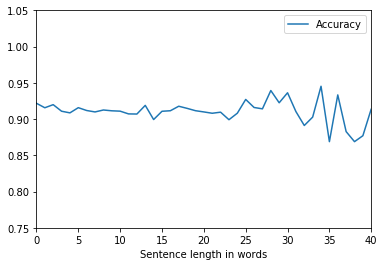

In [47]:
plt.plot([results[i][1] for i in range(len(results)) if len], label='Accuracy')
plt.xlim(0,40)
plt.ylim(0.75,1.05)
# plt.plot(l_er, label='Loss')
plt.xlabel('Sentence length in words')
plt.legend()
plt.show()

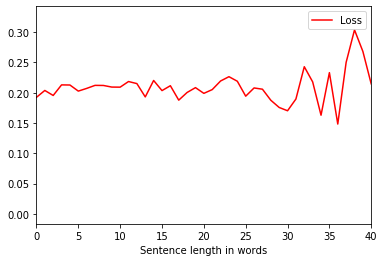

In [48]:
plt.plot([results[i][0] for i in range(len(results)) if len], label='Loss', c='red')
plt.xlim(0,40)
# plt.ylim(0.75,1.05)
plt.xlabel('Sentence length in words')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Sentence length distribution')

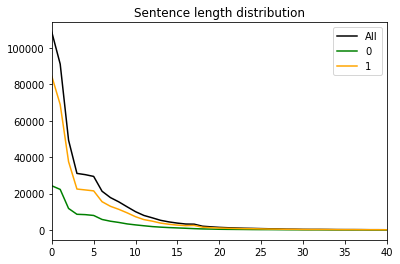

In [49]:
plt.plot(np.array(zeros) + np.array(ones), c='black', label='All')
plt.plot(np.array(ones), c='green', label='0')
plt.plot(np.array(zeros), c='orange', label='1')
plt.xlim(0,40)
plt.legend()
# plt.yscale('log')

plt.title('Sentence length distribution')

---

In [50]:
# PREDICTION TIME MEASUREMENT (based on 100 predictions, mainly for CPU/GPU speed comparison)

import time

# ------------
cntr = 0
for i in range(100):
    start = time.time()
    sentiment.predict([vocab_indices_vector(text_tokens('I would like to buy a new car'))])[0]
    end = time.time()
    
    cntr += np.around(end - start, 8)
# ------------

print(np.around(cntr/100, 8), 'seconds')

0.02562219 seconds
